## **Task**
Train and improve model for CIFAR10 + show confusion matrix and recall, precision etc.

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

## **Loading dataset**
I added data augmentation!



In [0]:
from torchvision import datasets, transforms
use_cuda = True

device = torch.device("cuda" if use_cuda else "cpu")

train_batch_size=64
test_batch_size=1000

transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(datasets.CIFAR10('data', train=True, download=True, transform=transform),
                    batch_size=train_batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(datasets.CIFAR10('data', train=False, transform=transform),
                    batch_size=test_batch_size, shuffle=True, **kwargs)

visualize_loader = torch.utils.data.DataLoader(datasets.CIFAR10('data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])),
                    batch_size=train_batch_size, shuffle=True, **kwargs)

Files already downloaded and verified
Files already downloaded and verified


## **Visualize some images**

tensor(6)


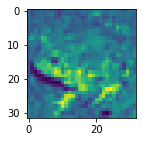

In [0]:
# visualize data
import seaborn as sn
fig=plt.figure(figsize=(2, 2))
data, label = next(iter(visualize_loader))
print(label[11])
img = data[11][0]
plt.imshow(img)
# for i in range(1, 51):
#     img = data[i][0]
#     fig.add_subplot(5, 10, i)
#     plt.imshow(img)
#     # img, vmin=0, vmax=1, cmap='gray'
plt.show()

You better not comment my green pictures. They are green, because you didn't sleep!

## **Model definition**

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 75, 5)
        self.bnm1 = nn.BatchNorm2d(75)
        self.conv2 = nn.Conv2d(75, 200, 5)
        self.bnm2 = nn.BatchNorm2d(200)
        self.conv3 = nn.Conv2d(200, 600, 3)
        self.bnm3 = nn.BatchNorm2d(600)
        self.conv4 = nn.Conv2d(600, 1200, 3)
        self.bnm4 = nn.BatchNorm2d(1200)
        self.conv5 = nn.Conv2d(1200, 2000, 3)
        self.bnm5 = nn.BatchNorm2d(2000)
        self.fc1 = nn.Linear(2*2*2000, 500)
        self.fc2 = nn.Linear(500, 200)
        self.fc3 = nn.Linear(200, 60)
        self.fc4 = nn.Linear(60, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bnm1(x)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2) 
        x = self.bnm2(x)
        x = F.relu(self.conv3(x))
        x = self.bnm3(x)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)       
        x = self.bnm4(x)
        x = F.relu(self.conv5(x))
        x = self.bnm5(x)
        x = x.view(-1, 2*2*2000)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)

## **Optimizer**

In [0]:
import torch.optim as optim

lr=0.05
momentum = 0.5

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

## **Functions for training and testing the model**
They were taken from example with MNIST-FASHION dataset

In [0]:
def train(model, device, train_loader, optimizer, epoch,log_interval):
    model.train()
    avg_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # zero the gradient buffers
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step() # Does the update
        avg_loss+=F.nll_loss(output, target, reduction='sum').item()
        
        if batch_idx % log_interval == 0:
          print('Train Epoch: {} [{:5.0f}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))
    avg_loss/=len(train_loader.dataset)
    return avg_loss

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    accuracy = 100. * correct / len(test_loader.dataset)
    time.sleep(0.2)
    return test_loss,accuracy

## **Training model**

In [0]:
epochs = 5
log_interval = 600
save_model = False

We break epochs into independent parts, where we change the parameters.

In [0]:
train_losses = []
test_losses = []
accuracy_list = []
for epoch in range(1, epochs + 1):
    trn_loss = train(model, device, train_loader, optimizer, epoch,log_interval)
    test_loss,accuracy = test(model, device, test_loader)
    train_losses.append(trn_loss)
    test_losses.append(test_loss)
    accuracy_list.append(accuracy)
    

for i in range(0, 6):
  optimizer = optim.SGD(model.parameters(), lr=lr/(i+1), momentum=momentum)
  for epoch in range(epochs + i*5 + 1, epochs + i*5 + 6):
      trn_loss = train(model, device, train_loader, optimizer, epoch,log_interval)
      test_loss,accuracy = test(model, device, test_loader)
      train_losses.append(trn_loss)
      test_losses.append(test_loss)
      accuracy_list.append(accuracy)
epochs = epoch

momentum = 0.1
for i in range(1, 4):
  lr = 0.001/i
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum*i)
  for epoch in range(epochs + (i-1)*3 + 1, epochs + (i-1)*3 + 4):
      trn_loss = train(model, device, train_loader, optimizer, epoch,log_interval)
      test_loss,accuracy = test(model, device, test_loader)
      train_losses.append(trn_loss)
      test_losses.append(test_loss)
      accuracy_list.append(accuracy)
      
epochs = epoch
momentum = 0.01
for i in range(1, 4):
  lr = 0.0001/i
  momentum *= i*i
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
  for epoch in range(epochs + (i-1)*3 + 1, epochs + (i-1)*3 + 4):
      trn_loss = train(model, device, train_loader, optimizer, epoch,log_interval)
      test_loss,accuracy = test(model, device, test_loader)
      train_losses.append(trn_loss)
      test_losses.append(test_loss)
      accuracy_list.append(accuracy)

torch.save(model.state_dict(),"mnist_cnn.pt") #saving

Train Epoch: 1 [    0/50000 (0%)]	Loss: 2.299377
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.050603

Test set: Average loss: 1.2490, Accuracy: 5368/10000 (53.7%)

Train Epoch: 2 [    0/50000 (0%)]	Loss: 1.045251
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.055744

Test set: Average loss: 0.9687, Accuracy: 6552/10000 (65.5%)

Train Epoch: 3 [    0/50000 (0%)]	Loss: 0.827433
Train Epoch: 3 [38400/50000 (77%)]	Loss: 0.861865

Test set: Average loss: 0.8905, Accuracy: 6908/10000 (69.1%)

Train Epoch: 4 [    0/50000 (0%)]	Loss: 0.969620
Train Epoch: 4 [38400/50000 (77%)]	Loss: 0.752427

Test set: Average loss: 0.7669, Accuracy: 7333/10000 (73.3%)

Train Epoch: 5 [    0/50000 (0%)]	Loss: 0.806832
Train Epoch: 5 [38400/50000 (77%)]	Loss: 0.696803

Test set: Average loss: 0.7010, Accuracy: 7576/10000 (75.8%)

Train Epoch: 6 [    0/50000 (0%)]	Loss: 0.764991
Train Epoch: 6 [38400/50000 (77%)]	Loss: 0.701730

Test set: Average loss: 0.6957, Accuracy: 7644/10000 (76.4%)

Train Epoch: 7 [    0/50000 

Making confusion Matrix with sklearn

In [0]:

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
y_true = []
y_pred = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(1000):
            label = labels[i]
            y_true.append(classes[labels[i]])
            y_pred.append(classes[predicted[i]])
            class_correct[label] += c[i].item()
            class_total[label] += 1


import sklearn.metrics as metr
mtrx = metr.confusion_matrix(y_true, y_pred, labels=classes)
print("Confusion matrix: \n", mtrx)

precisions = [0,0,0,0,0,0,0,0,0,0]
recalls = [0,0,0,0,0,0,0,0,0,0]
f1_scores = [0,0,0,0,0,0,0,0,0,0]
for i in range(10):
    suma_row=0
    suma_column=0
    for j in range(10):
        suma_row += mtrx[i][j]
        suma_column += mtrx[j][i]
    precisions[i] = mtrx[i][i]/(suma_row)*100
    recalls[i] = mtrx[i][i]/(suma_column)*100
    f1_scores[i] = 2 * (precisions[i] * recalls[i])/(precisions[i] + recalls[i])
    print('Accuracy of %5s : %2d %%  Precision: %4s %%  Recall: %4d %%  F1-score: %4s %%' % (classes[i], 100 * class_correct[i] / class_total[i], precisions[i], recalls[i], f1_scores[i]))


Confusion matrix: 
 [[855   9  26  12   8   0   5   7  51  27]
 [ 19 873   3   1   1   0   3   2  37  61]
 [ 52   9 759  28  48  20  34  28  11  11]
 [ 22   4  74 632  60 107  32  32  17  20]
 [ 14   3  45  21 812  10  18  47  21   9]
 [  9   7  44 120  45 701  11  44   4  15]
 [  9   4  32  31  29  10 867   5   6   7]
 [ 15  10  17  29  27  21   2 852   5  22]
 [ 41   8   7   7   0   0   3   4 883  47]
 [ 17  35   4   6   0   1   3   3  22 909]]
